In [1]:
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl

## Load pre-tokenized train/val sets

In [2]:
def load_data(filepath, size):
    x1 = []
    x2 = []
    y = []
    with open(filepath) as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        for row in reader:
            if row == ['sentence1', 'sentence2', 'label']:
                pass
            else:
                x1.append(row[0].split())
                x2.append(row[1].split())
                if row[2] == 'contradiction':
                    y.append(0.0)
                elif row[2] == 'entailment':
                    y.append(1.0)
                elif row[2] == 'neutral':
                    y.append(2.0)
    assert len(x1)==size, "incorrect number of premise"
    assert len(x2)==size, "incorrect number of hypothesis"
    assert len(y)==size, "incorrect number of label"
    
    return x1,x2,y

In [3]:
train_x1, train_x2, train_y = load_data('hw2_data/snli_train.tsv', 100000)
val_x1, val_x2, val_y = load_data('hw2_data/snli_val.tsv', 1000)

In [4]:
# get the maximum sentence length of premise and hypothesis in the training set, respectively, 
# based on the percentile of sentence lengths 
def get_length(x, percent=99):
    length = [len(i) for i in x]
    return int(np.percentile(length, percent))

In [5]:
MAX_SENTENCE_LENGTH_X1 = get_length(train_x1)
MAX_SENTENCE_LENGTH_X2 = get_length(train_x2)

In [6]:
print(MAX_SENTENCE_LENGTH_X1, MAX_SENTENCE_LENGTH_X2)

34 19


## Build vocab list and transform data into indices
### vocabulary list obtained from top frequent tokens of fastText pre-trained word embeddings

In [7]:
words_to_load = 60000
PAD_IDX = 0
UNK_IDX = 1

In [8]:
with open('wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    np.random.seed(1)
    loaded_embeddings_ft[UNK_IDX] = np.random.rand(300)
    token2id = {'<pad>':PAD_IDX, '<unk>':UNK_IDX}
    id2token = {PAD_IDX:'<pad>', UNK_IDX:'<unk>'}
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        token2id[s[0]] = i+2
        id2token[i+2] = s[0]

In [9]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [10]:
train_x1_indices = token2index_dataset(train_x1)
train_x2_indices = token2index_dataset(train_x2)
val_x1_indices = token2index_dataset(val_x1)
val_x2_indices = token2index_dataset(val_x2)

## DataLoader

In [11]:
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list1, data_list2, target_list):
        """
        @param data_list: list of SNLI tokens 
        @param target_list: list of SNLI targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))

    def __len__(self):
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when yo-u call dataset[i]
        """
        
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH_X1]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH_X2]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1), token_idx2, len(token_idx2), label]

def SNLI_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[1])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH_X1-datum[1])), 
                                mode="constant", constant_values=0)
        padded_vec2 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH_X2-datum[3])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        data_list2.append(padded_vec2)
    
    return [torch.from_numpy(np.array(data_list1)), torch.LongTensor(length_list1), 
            torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list2),torch.LongTensor(label_list)]

In [12]:
BATCH_SIZE = 32
train_dataset = SNLIDataset(train_x1_indices, train_x2_indices, train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(val_x1_indices, val_x2_indices, val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

# Models
## RNN (bi-directional GRU)

In [13]:
class RNN(nn.Module):
    def __init__(self, hidden_size1, hidden_size2, hidden_size3, num_layers, num_classes, emb_size=300):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size1, self.hidden_size2, self.hidden_size3 = \
        num_layers, hidden_size1, hidden_size2, hidden_size3
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(loaded_embeddings_ft)).float()
        self.rnn1 = nn.GRU(emb_size, hidden_size1, num_layers, batch_first=True, bidirectional=True)
        self.rnn2 = nn.GRU(emb_size, hidden_size2, num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(hidden_size1+hidden_size2, hidden_size3)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size3, num_classes)

    def init_hidden(self, batch_size, hidden_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        hidden = torch.randn(self.num_layers*2, batch_size, hidden_size)
        return hidden

    def forward(self, x1, lengths1, x2, lengths2):
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        _, idx_sort1 = torch.sort(lengths1, dim=0, descending=True)
        _, idx_unsort1 = torch.sort(idx_sort1, dim=0)
        _, idx_sort2 = torch.sort(lengths2, dim=0, descending=True)
        _, idx_unsort2 = torch.sort(idx_sort2, dim=0)
        
        # reset hidden state
        self.hidden1 = self.init_hidden(batch_size1, self.hidden_size1)
        self.hidden2 = self.init_hidden(batch_size2, self.hidden_size2)

        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        # pack padded sequence
        embed1 = embed1.index_select(0, idx_sort1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, lengths1.index_select(0, idx_sort1).numpy(), batch_first=True)
        embed2 = embed2.index_select(0, idx_sort2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, lengths2.index_select(0, idx_sort2).numpy(), batch_first=True)
        # fprop though RNN
        rnn_out1, self.hidden1 = self.rnn1(embed1, self.hidden1)
        self.hidden1 = self.hidden1.index_select(1, idx_unsort1)
        rnn_out2, self.hidden2 = self.rnn2(embed2, self.hidden2)
        self.hidden2 = self.hidden2.index_select(1, idx_unsort2)

        combined_vector = torch.cat([self.hidden1, self.hidden2],dim=-1)
        rnn_out = torch.sum(combined_vector, dim=0)

        fc_out = self.linear1(rnn_out)
        fc_out = self.relu(fc_out)
        logits = self.linear2(fc_out)
        
        return logits

## CNN

In [14]:
class CNN(nn.Module):
    def __init__(self, kernel_pad, hidden_size1, hidden_size2, num_layers, num_classes, emb_size=300):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size1, self.hidden_size2 = \
        num_layers, hidden_size1, hidden_size2
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(loaded_embeddings_ft)).float()
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size1, kernel_size=kernel_pad[0], padding=kernel_pad[1])
        self.conv2 = nn.Conv1d(hidden_size1, hidden_size1, kernel_size=kernel_pad[0], padding=kernel_pad[1])
        self.conv3 = nn.Conv1d(emb_size, hidden_size1, kernel_size=kernel_pad[0], padding=kernel_pad[1])
        self.conv4 = nn.Conv1d(hidden_size1, hidden_size1, kernel_size=kernel_pad[0], padding=kernel_pad[1])
        
        self.maxpool1 = nn.MaxPool1d(MAX_SENTENCE_LENGTH_X1)
        self.maxpool2 = nn.MaxPool1d(MAX_SENTENCE_LENGTH_X2)

        self.linear1 = nn.Linear(2*hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x1, lengths1, x2, lengths2):
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()

        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, hidden1.size(-1), seq_len1)
        hidden1 = self.maxpool1(hidden1)
        
        hidden2 = self.conv3(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))
        hidden2 = self.conv4(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, hidden2.size(-1), seq_len2)   
        hidden2 = self.maxpool2(hidden2)
        
        combined_vector = torch.cat([hidden1, hidden2],dim=1)
        cnn_out = torch.sum(combined_vector, dim=-1)
        
        fc_out = self.linear1(cnn_out)
        fc_out = self.relu(fc_out)
        logits = self.linear2(fc_out)
        return logits

## Train/Test Functions

In [15]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, lengths1, data2, lengths2, labels in loader:
        data_batch1, lengths_batch1, data_batch2, lengths_batch2, label_batch = \
        data1, lengths1, data2, lengths2, labels
        outputs = F.softmax(model(data_batch1, lengths_batch1, data_batch2, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [16]:
def train_model(model, learning_rate, num_epochs, adj, lr_decay=0.5, save=False, model_name='rnn'):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Number of trainable parameters:{}".format(params))
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    if adj:
        scheduler = StepLR(optimizer, step_size=1, gamma=lr_decay)

    train_ls = []
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
        if adj:
            scheduler.step()
        for i, (data1, lengths1, data2, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, lengths1, data2, lengths2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_ls.append(loss)
            # validate every 1000 iterations
            if i > 0 and i % 1000 == 0:
                # validate
                train_acc.append(test_model(train_loader, model))
                val_acc.append(test_model(val_loader, model))
    
    val_acc_last = test_model(val_loader, model)
    print("Val Accuracy:{}".format(val_acc_last))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_ls)
    plt.xlabel("i")
    plt.ylabel("Train Loss")
    
    plt.subplot(2, 1, 2)
    plt.plot(train_acc, color='b', label='Train Acc')
    plt.plot(val_acc, color='r', label='Val Acc')
    plt.xlabel("i%1000")
    plt.ylabel("Train/Val Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    if save:
        torch.save(model, 'best_snli_model_'+str(model_name)+'.pth')
        #torch.save(model.state_dict(), 'best_snli_model_'+str(model_name)+'.pth')
        return model

# Training
### RNN

Number of trainable parameters:660703
Val Accuracy:67.6


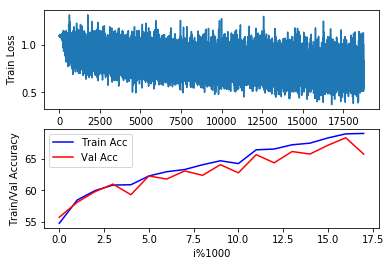

/anaconda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
model = RNN(hidden_size1=150, hidden_size2=100, hidden_size3=50, num_layers=1, num_classes=3)
train_model(model, 3e-4, 6, False, save=True)

Number of trainable parameters:660703
Val Accuracy:66.3


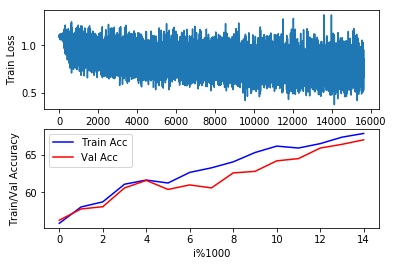

In [175]:
model = RNN(hidden_size1=150, hidden_size2=100, hidden_size3=50, num_layers=1, num_classes=3)
train_model(model, 3e-4, 5, False)

Number of trainable parameters:492603
Val Accuracy:67.7


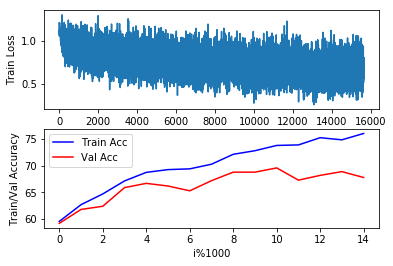

/anaconda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [43]:
model = RNN(hidden_size1=100, hidden_size2=100, hidden_size3=50, num_layers=1, num_classes=3)
model_cnn = train_model(model, 3e-3, 5, False, save=True)

In [44]:
model_rnn = model_cnn #fix typo

Number of trainable parameters:492603
Val Accuracy:63.2


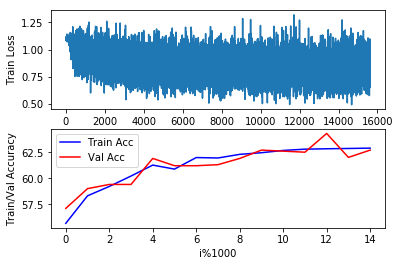

In [233]:
model = RNN(hidden_size1=100, hidden_size2=100, hidden_size3=50, num_layers=1, num_classes=3)
train_model(model, 3e-4, 5, True)

Number of trainable parameters:660703
Val Accuracy:63.4


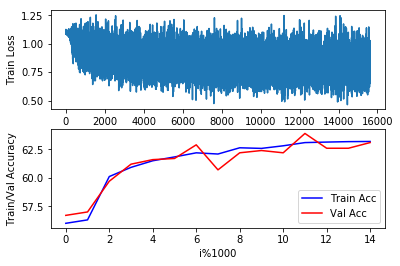

In [17]:
model = RNN(hidden_size1=150, hidden_size2=100, hidden_size3=50, num_layers=1, num_classes=3)
train_model(model, 3e-4, 5, True)

Number of trainable parameters:660703
Val Accuracy:62.3


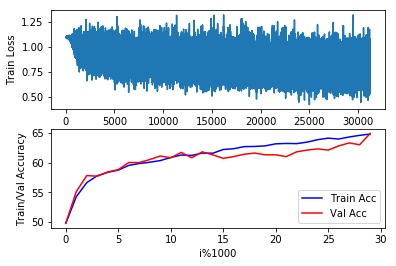

/anaconda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


RNN(
  (embedding): Embedding(60002, 300)
  (rnn1): GRU(300, 150, batch_first=True, bidirectional=True)
  (rnn2): GRU(300, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=250, out_features=50, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=50, out_features=3, bias=True)
)

In [24]:
model = RNN(hidden_size1=150, hidden_size2=100, hidden_size3=50, num_layers=1, num_classes=3)
train_model(model, 1e-4, 10, False, save=True)

### CNN

Number of trainable parameters:250603
Val Accuracy:63.8


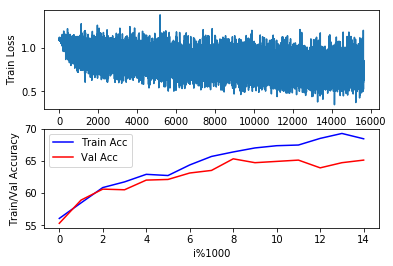

In [226]:
model = CNN(kernel_pad=[3,1], hidden_size1=100, hidden_size2=50, num_layers=2, num_classes=3)
train_model(model, 3e-4, 5, False, model_name='cnn')

Number of trainable parameters:410603
Val Accuracy:64.6


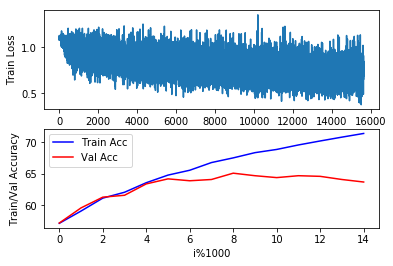

In [21]:
model = CNN(kernel_pad=[5,2], hidden_size1=100, hidden_size2=50, num_layers=2, num_classes=3)
train_model(model, 3e-4, 5, False, model_name='cnn')

Number of trainable parameters:641203
Val Accuracy:64.8


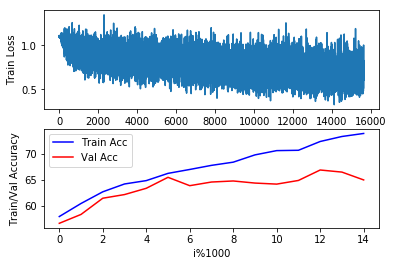

/anaconda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [66]:
model = CNN(kernel_pad=[3,1], hidden_size1=200, hidden_size2=100, num_layers=2, num_classes=3)
train_model(model, 3e-4, 5, False,  save= True, model_name='cnn')

Number of trainable parameters:641203
Val Accuracy:64.3


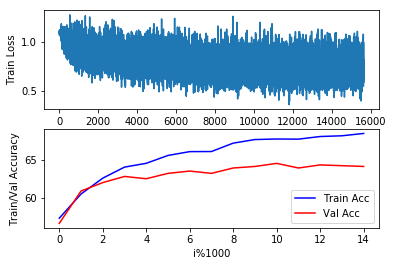

/anaconda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [68]:
model = CNN(kernel_pad=[3,1], hidden_size1=200, hidden_size2=100, num_layers=2, num_classes=3)
train_model(model, 3e-4, 5, True, save=True, model_name='cnn')

Number of trainable parameters:1041203
Val Accuracy:65.0


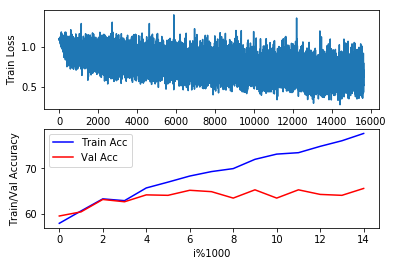

/anaconda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
model = CNN(kernel_pad=[5,2], hidden_size1=200, hidden_size2=100, num_layers=2, num_classes=3)
model_cnn = train_model(model, 3e-4, 5, False, save=True, model_name='cnn')

Number of trainable parameters:1041203
Val Accuracy:64.0


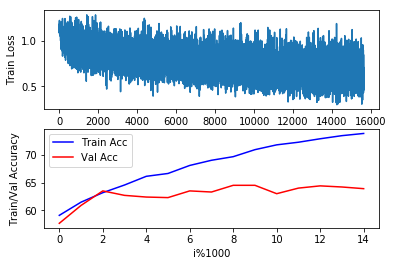

/anaconda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [67]:
model = CNN(kernel_pad=[5,2], hidden_size1=200, hidden_size2=100, num_layers=2, num_classes=3)
train_model(model, 3e-3, 5, True, save=True, model_name='cnn')

## Sample predictions on best model (model_rnn)

In [70]:
model_rnn.eval()
index = []
for data1, lengths1, data2, lengths2, labels in val_loader:
    data_batch1, lengths_batch1, data_batch2, lengths_batch2, label_batch = \
    data1, lengths1, data2, lengths2, labels
    outputs = F.softmax(model_rnn(data_batch1, lengths_batch1, data_batch2, lengths_batch2), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    index += (predicted.numpy() == labels.view_as(predicted).numpy()).tolist()

In [71]:
correct_index = []
wrong_index = []
for i, val in enumerate(index):
    if val[0] == True:
        correct_index.append(i)
    else:
        wrong_index.append(i)

### 3 correct predictions

In [72]:
three_list = [i for i in np.random.choice(correct_index, 3)]
for i in three_list:
    print("premise: {}".format(" ".join(val_x1[i])))
    print("hypothesis: {}".format(" ".join(val_x2[i])))
    print("True label: {}".format(val_y[i]))
    print('\t')

premise: Trying very hard not to blend any of the yellow paint into the white .
hypothesis: Someone is baking a cake .
True label: 0.0
	
premise: An overweight man in a blue and black hooded sweatshirt works on a laptop computer outdoors .
hypothesis: A man does some work while sitting outside at a park .
True label: 1.0
	
premise: A male bartender dressed in all black with his sleeves rolled up to elbow height making a drink in a martini glass .
hypothesis: A person in black
True label: 1.0
	


### 3 incorrect predictions

In [73]:
three_list = [i for i in np.random.choice(wrong_index, 3)]
for i in three_list:
    print("premise: {}".format(" ".join(val_x1[i])))
    print("hypothesis: {}".format(" ".join(val_x2[i])))
    print("True label: {}".format(val_y[i]))
    print('\t')

premise: This lady had a lot of freckles .
hypothesis: There is a woman .
True label: 1.0
	
premise: A young man in a green sweatshirt holds a young boy with a blue backpack and a yellow sweatshirt in front of a run-down building .
hypothesis: A man is holding a young boy .
True label: 2.0
	
premise: A swimming dog with a small branch in its mouth .
hypothesis: A dog is ice skating .
True label: 0.0
	
